# EXERCISE 2
---

### (a) Replicate Table 1 and 2 for the US economy from - ideally - 1950 Q1 to the newest data you can find (either 2020 or 2023). You can use real GDP instead of GNP if you want.

### *Solution*

Import libraries (and set output options to visualise tables in a tidy fashion) and define useful functions

In [1]:
import fredapi as fa
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
#function to compute correlations

def crosscorr(datax, datay):
    '''
    Thanks to @cfulton
    computes a n-lag crosscorrelation with ccf function, and it is able to compute 
    correlation with negative lags.
    '''
    corr = []
    pos = sm.tsa.stattools.ccf(datax, datay, adjusted = False)  
    neg = sm.tsa.stattools.ccf(datax[::-1], datay[::-1], adjusted = False)[::-1]  
    for i in neg[-5:-1]: #from t-1 to t-4
        corr.append(i)
    for j in pos[:5]: #from t to t+4
        corr.append(j)
    return corr



####  **TABLE 1**

Generate the API to retrieve the data from FRED website

In [3]:
fred = fa.Fred(api_key='a474abb9f1a26c2428ff91f399fcb3a6')

Retrieve all the available data, then add the missing variables, namely total hours worked and employment. Finally, apply a log transformation.

In [4]:
#import data
gnp = fred.get_series("GNP")
gnp.name = "gnp"     #real gdp 

pcdg = fred.get_series("PCDG")
pcdg.name = "cd"    #private consumption, durable goods

pcnd = fred.get_series("PCND")
pcnd.name = "cnd"    #private consumption non durable goods

ahetpi = fred.get_series("AHETPI")  
ahetpi.name = "avew"   #average wage per hour, total private

awhnonag = fred.get_series("AWHNONAG")
awhnonag.name = "aveh"    #average hours worked per employee


In [5]:
#import data
h_empl = pd.read_excel("total-economy-hours-employment.xlsx")  #for total hours and employment

hours = h_empl.iloc[0][5:]   #total hours

employment = h_empl.iloc[15][5:]   #employment

#change the date format
qs = hours.index.str.replace(r' ', r'-')
date = pd.PeriodIndex(qs, freq = "Q").to_timestamp()
#set the new date as index to join the variables
hours.index = employment.index = date

In [6]:
#inner join to retain common dates
data1 = pd.merge(gnp, pcnd, left_index = True, right_index = True)    #gnp, non durable goods

data1 = pd.merge(data1, pcdg, left_index = True, right_index = True)   #durable goods

data1["h"] = hours    # total hours worked

data1 = pd.merge(data1, awhnonag, left_index = True, right_index = True)  #average hours worked

data1["l"] = employment    #employment

data1["gnp/l"] = data1["gnp"]/data1["l"]   #productivity

data1 = pd.merge(data1, ahetpi, left_index = True, right_index = True)   #average hourly wage

#data1

In [7]:
data1 = data1.apply(pd.to_numeric)
log_data1 = np.log(data1)
#log_data1

Extract the trend and cycle components of the series, in order to be able to study "stylised facts of the business cycle", as requested by the exercise.

In [8]:
cycle1 = pd.DataFrame()
trend1 = pd.DataFrame()

for i in log_data1.columns.values:
    cyclical, trendy = sm.tsa.filters.hpfilter(log_data1[i], lamb=1600)
    cycle1[i] = cyclical
    trend1[i] = trendy

#de-trended data
#cycle1  

Recreate the table obtained by Cooley and Prescott 1995. 
- Compute standard deviations *100 (sd%)
- compute autocorrelation of output series
- compute cross correlation of output with the other variables

In [9]:
table1 = pd.DataFrame(columns = ["sd%", "t-4", "t-3", "t-2", "t-1", "t", "t+1", "t+2", "t+3", "t+4"])

In [10]:
#compute standard deviations
sd = []
for i in cycle1.columns.values:
    sd.append(cycle1[i].std()*100)

table1["sd%"]= sd

In [11]:
table1.set_index(cycle1.columns.values, inplace = True)

In [12]:
#fill the table with cross correlations
for i in cycle1.columns.values:
    table1.loc[i, "t-4":"t+4"] = crosscorr(cycle1["gnp"], cycle1[i])

In [13]:
table1

,sd%,t-4,t-3,t-2,t-1,t,t+1,t+2,t+3,t+4
gnp,1.56,0.08,0.29,0.53,0.73,1.00,0.73,0.53,0.29,0.08
cnd,1.96,0.12,0.27,0.45,0.56,0.71,0.56,0.43,0.24,0.05
cd,3.97,-0.33,-0.21,-0.02,0.15,0.49,0.57,0.55,0.49,0.41
h,1.71,0.17,0.36,0.54,0.71,0.87,0.62,0.45,0.26,0.10
aveh,0.54,-0.28,-0.18,-0.02,0.21,0.43,0.43,0.44,0.42,0.34
l,1.46,0.28,0.45,0.60,0.73,0.85,0.56,0.38,0.18,0.02
gnp/l,0.84,-0.33,-0.25,-0.07,0.09,0.39,0.39,0.33,0.23,0.11
avew,0.66,0.14,0.16,0.15,0.10,-0.06,-0.01,-0.09,-0.13,-0.16


In [14]:
#table1.to_latex()

#### **TABLE 2**

Following a similar procedure 

In [15]:
#import data
y = fred.get_series("A939RC0Q052SBEA")
y.name = "y"     #per capita outcome

c = fred.get_series("A796RC0Q052SBEA")
c.name = "c"    #per capita consumption

i = fred.get_series("A795RC0Q052SBEA")
i.name = "i"    #per capita investment

w = fred.get_series("AHETPI")  
w.name = "w"   #real wage (compensation per hour)

pop =  fred.get_series("B230RC0Q173SBEA")  
pop.name = "population"   #real wage (compensation per hour)
pop = pop[4:]    #to perform the ratio with hours i remove the missin data from 1948


In [16]:
#import data

h_empl = pd.read_excel("total-economy-hours-employment.xlsx")  
hours = h_empl.iloc[0][5:]
#change the date format
qs = hours.index.str.replace(r' ', r'-')
date = pd.PeriodIndex(qs, freq = "Q").to_timestamp()
#set the new date as index to join the variables
hours.index = date
hours = hours[4:]
hours = hours.apply(pd.to_numeric)
hours = hours*1e3

In [17]:
#create the dataframe with common dates to retrieve hours per capta
h_pc = pd.merge(hours, pop, left_index = True, right_index = True)
h_pc = h_pc.rename({h_pc.columns[0]: "hours", h_pc.columns[1]: "pop"}, axis = 1)

In [18]:
data2 = pd.merge(y, c, left_index = True, right_index = True)  

data2 = pd.merge(data2, i, left_index = True, right_index = True)  

data2["n"] = h_pc["hours"]/h_pc["pop"]  # total hours worked

data2["y/n"] = data2["y"]/data2["n"]   

data2 = pd.merge(data2, w, left_index = True, right_index = True)  

#we add interest rates after, since we do not need to log transform it

#data2

In [19]:
#data2 = data2.apply(pd.to_numeric)
log_data2 = np.log(data2)

Add data about real interest rates (no log)

In [20]:
r = pd.read_excel("rates.xls")
r = r.set_index("observation_date", drop= True)
log_data2["r"] = r   #rates
 
#log_data2

In [21]:
#de trend data
cycle2 = pd.DataFrame()
trend2 = pd.DataFrame()

for i in log_data2.columns.values:
    cyclical, trendy = sm.tsa.filters.hpfilter(log_data2[i], lamb=1600)
    cycle2[i] = cyclical
    trend2[i] = trendy

In [22]:
#cycle2

Finally add data about total factor productivity

In [23]:
#retrieve capital
A = pd.ExcelFile("quart_tfp.xlsx")   #400 * change in natural log
A = pd.read_excel(A, 'quarterly')

A.set_index("date", inplace= True)
A = A["1964:Q1":"2022:Q4"]   #remove statistics at the end of the table and retain years in common with y only 

In [24]:
qs = A.dLP.index.str.replace(':', '-')
qs
date = pd.PeriodIndex(qs, freq = "Q").to_timestamp()
date
A.index = date
tfp = (A.dLP/400)

In [25]:
#tfp

We do not need to use hp filter to extract the cycical component, since the provided data is already a record of 400 * changes in natural logarithm. 
Therefore, we just need to divide by 400 and we have the fluctuations (from trend) in log and we simply add it to the cycle2 data.
Then, we can compute the requested metrics.

In [26]:
cycle2["A"] = tfp

In [27]:
cycle2 = cycle2[:-1]  #remove last quarter because A is not available
#cycle2

In [57]:
#create and fill the table
table2 = pd.DataFrame(columns = ["sd", "rsd", "autocorr", "contcorr"])

In [58]:
#compute standard deviation
sd = []
for i in cycle2.columns.values:
    sd.append(cycle2[i].std()*100)

table2["sd"] = sd

In [59]:
table2.set_index(cycle2.columns.values, inplace = True)

In [60]:
table2.loc["r", "sd":"rsd"] = (table2.loc["r", "sd":"rsd"]/100)

In [61]:
#relative sd
rel_sd = table2["sd"]/table2.loc["y", "sd"]  #cycle2["y"].std()
table2["rsd"] = rel_sd

#first order autocorrelation
table2["autocorr"] = cycle2.apply(lambda x: x.autocorr())

#contemporary correlation
crosscor = []
for i in cycle2.columns.values:
    crosscor.append(cycle2["y"].corr(cycle2[i]))

table2["contcorr"] = crosscor

In [62]:
table2

,sd,rsd,autocorr,contcorr
y,1.56,1.00,0.74,1.00
c,1.98,1.27,0.80,0.71
i,3.99,2.56,0.73,0.52
n,1.72,1.11,0.79,0.87
y/n,0.84,0.54,0.74,0.06
w,0.66,0.42,0.79,-0.08
r,0.73,0.47,0.80,0.41
A,0.70,0.45,0.11,-0.26
g,3.33,2.13,0.45,-0.57


In [63]:
#table2.to_latex()

---
---

### (b) Verify whether or not the following business cycle facts from Cooley and Prescott (1995) still hold today:

### *Solution*

The questions can be answered by looking at the two tables we recreated before, however plots help to better understand results visually.


- *Consumption is smoother than output*: No. In fact, in our table2 sd of output is smaller than sd of consumption

In [64]:
#If we look at data till 1991 we can see that consumption is not smoother than output. This is contradictory and the reason may be that our data 
#starts from 1964
cp_y = cycle2.loc[:"1991-10-01"].y.std()*100   #output
cp_c = cycle2.loc[:"1991-10-01"].c.std()*100   #consumption

#cp_y, cp_c

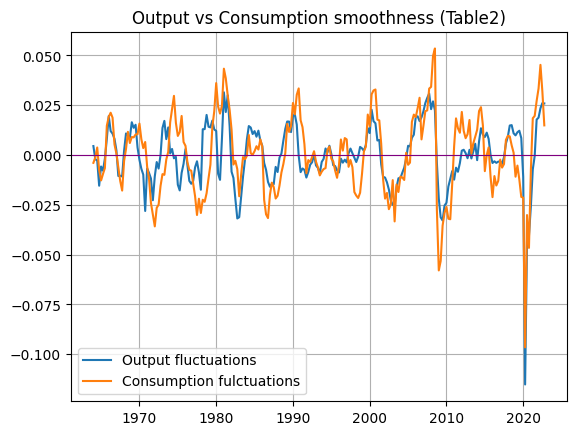

In [65]:
plt.plot(cycle2.y, label = "Output fluctuations")   
plt.plot(cycle2.c, label = "Consumption fulctuations")
plt.legend()
plt.title("Output vs Consumption smoothness (Table2)")
plt.grid()
plt.axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
plt.show()  

- *Volatility in GNP is similar in magnitude to volatility in total hours*: Yes, they have the same standard deviation magnitude order.

In [66]:
#cycle1.gnp.std(), cycle1.h.std() 

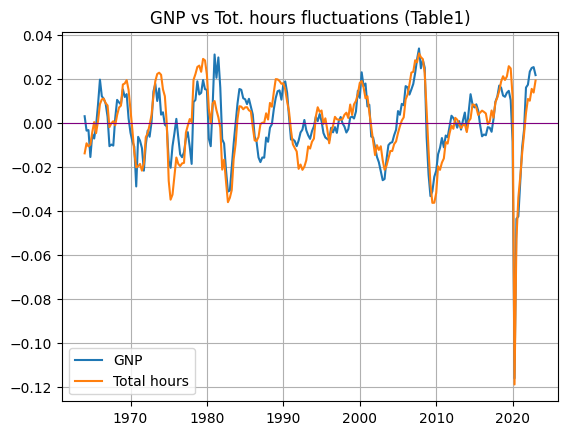

In [67]:
plt.plot(cycle1.gnp, label = "GNP")
plt.plot(cycle1.h, label = "Total hours")
plt.legend()
plt.title("GNP vs Tot. hours fluctuations (Table1)")
plt.grid()
plt.axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
plt.show()

- *Volatility in employment is greater than volatility in average hours. Therefore most labour market adjustments operate on the extensive rather than intensive margin*: Yes. Moreover, it seems that after 1990 the average hours volatility decreased.

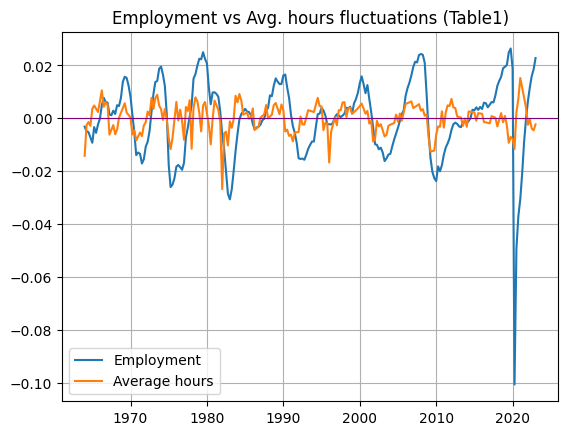

In [68]:
plt.plot(cycle1.l, label = "Employment")
plt.plot(cycle1.aveh, label = "Average hours")
plt.legend()
plt.title("Employment vs Avg. hours fluctuations (Table1)")
plt.grid()
plt.axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
plt.show()

- *Productivity is slightly pro-cyclical*: Yes. Although before 1991 the min and max are really close to each other, we can observe that there were both more frequent and higher peaks than throughs.

In [69]:
print("The sum of fluctuations is positive: ", sum(cycle1["gnp/l"]) > 0)
print("It is :", sum(cycle1["gnp/l"]))

The sum of fluctuations is positive:  True
It is : 3.006483950684924e-12


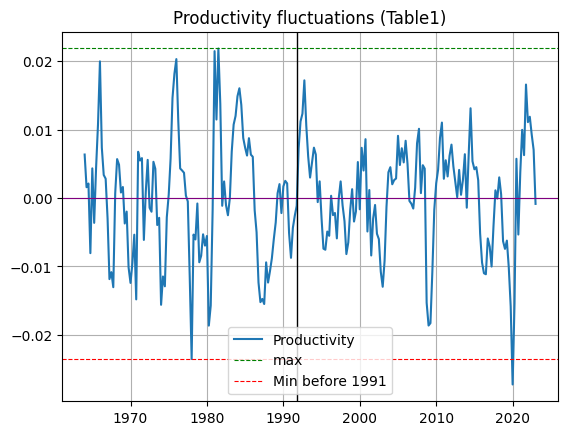

In [70]:
plt.plot(cycle1["gnp/l"], label = "Productivity")
plt.axhline(y = max(cycle1["gnp/l"]), color = 'g', linestyle = '--', lw = 0.8, label = "max")
plt.axhline(y = min(cycle1.loc[:"1991-10-01", "gnp/l"]), color = 'r', linestyle = '--', lw = 0.8, label = "Min before 1991")    #plot minimum till 91
plt.axhline(y = 0, color = 'purple', linestyle = '-', lw = 0.8)
plt.axvline(pd.to_datetime('1991-10-01'), color = "black", linestyle='-', lw=1)
plt.legend()
plt.title("Productivity fluctuations (Table1)")
plt.grid()

plt.show()

-  *Wages are less variable than productivity*: Yes

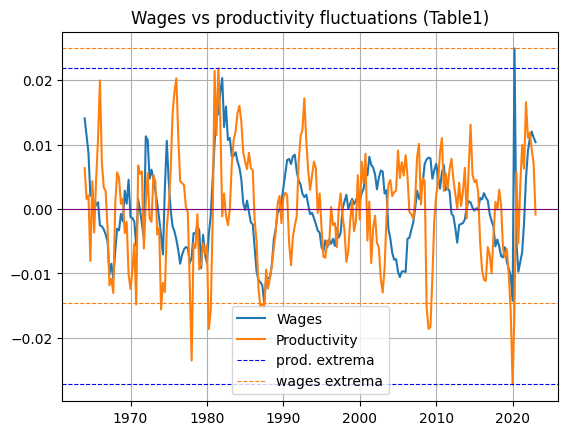

In [71]:
plt.plot(cycle1.avew, label = "Wages")
plt.plot(cycle1["gnp/l"], label = "Productivity")
plt.title("Wages vs productivity fluctuations (Table1)")

plt.axhline(y = max(cycle1["gnp/l"]), color = 'b', linestyle = '--', lw = 0.8, label = "prod. extrema")
plt.axhline(y = min(cycle1["gnp/l"]), color = 'b', linestyle = '--', lw = 0.8) 
plt.axhline(y = max(cycle1.avew), color = 'tab:orange', linestyle = '--', lw = 0.8, label = "wages extrema")
plt.axhline(y = min(cycle1.avew), color = 'tab:orange', linestyle = '--', lw = 0.8) 
plt.axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)

plt.legend()
plt.grid()
plt.show()

- *There is no correlation between wages and output (nor with employment for that matter)*: There is no correlation between wages and output, but there is correlation between employment and output (in table1 the contemporaneous correlation is 0.85)

---
---

### (c) Verify whether or not the following business cycle facts from King and Rebelo (1999) still hold today:

### *Solution*

The questions can be answered by looking at the two tables we recreated before, however plots help to better understand results visually.

• *Consumption of non-durables is less volatile than output*: No, it is more volatile

• *Consumer durables are more volatile than output*: Yes, by far.

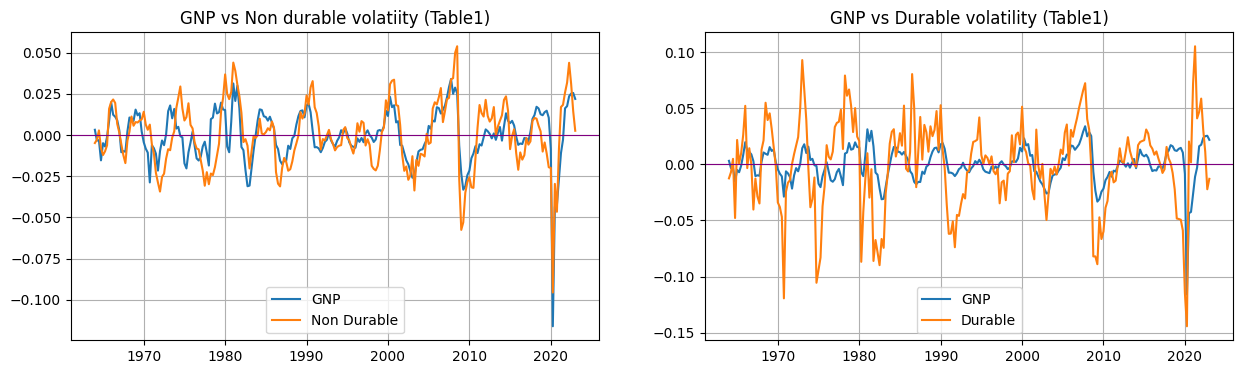

In [72]:
figure, axis = plt.subplots(1, 2)
figure.set_size_inches(15,4)

axis[0].plot(cycle1.gnp, label = "GNP")
axis[0].plot(cycle1.cnd, label = "Non Durable")
axis[0].axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
axis[0].set_title("GNP vs Non durable volatiity (Table1)")
axis[0].grid()
axis[0].legend(loc = 8)

axis[1].plot(cycle1.gnp, label = "GNP")
axis[1].plot(cycle1.cd, label = "Durable")
axis[1].axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
axis[1].set_title("GNP vs Durable volatility (Table1)")
axis[1].grid()
axis[1].legend()


plt.show()

• *Investment is three times more volatile than output*: Not 3 times anymore, but 2.56

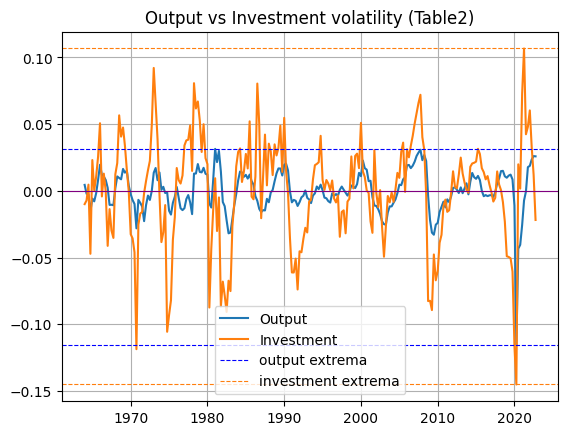

In [73]:
plt.plot(cycle2.y, label = "Output")
plt.plot(cycle2.i, label = "Investment")

plt.axhline(y = max(cycle2.y), color = 'b', linestyle = '--', lw = 0.8, label = "output extrema")
plt.axhline(y = min(cycle2.y), color = 'b', linestyle = '--', lw = 0.8) 
plt.axhline(y = max(cycle2.i), color = 'tab:orange', linestyle = '--', lw = 0.8, label = "investment extrema")
plt.axhline(y = min(cycle2.i), color = 'tab:orange', linestyle = '--', lw = 0.8) 
plt.axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)

plt.title("Output vs Investment volatility (Table2)")
plt.legend()
plt.grid()
plt.show()

• *Government expenditures are less volatile than output*: No, they are more volatile.


In order to answer this question we need to import an additional Series from FRED (https://fred.stlouisfed.org/series/W068RCQ027SBEA)

In [74]:
g = fred.get_series("W068RCQ027SBEA")
g.name = "g"     #total government expenditures

g = np.log(g)
log_data2["g"] = g

In [75]:
#de-trend g
cyclical, trendy = sm.tsa.filters.hpfilter(log_data2.g, lamb=1600)
cycle2["g"] = cyclical
trend2["g"] = trendy

#cycle2

In [76]:
print("Government expenditure sd%: ", cycle2.g.std()*100)
print("Output sd%: ", cycle2.y.std()*100)

Government expenditure sd%:  3.32923620771435
Output sd%:  1.559607120295569


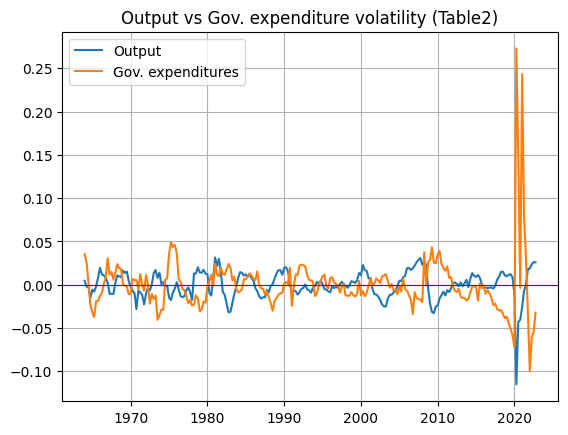

In [77]:
plt.plot(cycle2.y, label = "Output")
plt.plot(cycle2.g, label = "Gov. expenditures")
plt.legend()
plt.title("Output vs Gov. expenditure volatility (Table2)")
plt.grid()
plt.axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
plt.show()


• *Total hours worked are about the same volatility as output*: The relative standard deviation between y and n in table2 is 1.10, not excessively distant from 1 (same volatility). We can directly confront the variable total hours worked h in table1, reaching the same conclusion (1.56 vs 1.76, not that distant).

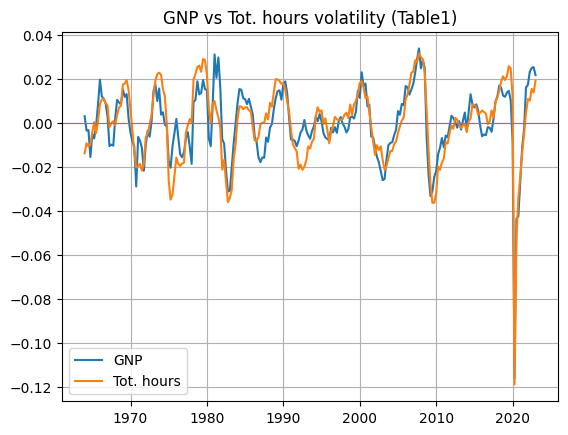

In [78]:

plt.plot(cycle1.gnp, label = "GNP")
plt.plot(cycle1.h, label = "Tot. hours")   
plt.legend()
plt.title("GNP vs Tot. hours volatility (Table1)")
plt.grid()
plt.axhline(y = 0, color = 'tab:purple', linestyle = '-', linewidth = 0.8)
plt.show()



• *Capital is much less volatile than output:* Yes. Capital standard deviation is 0.31 (vs 1.56). 
Applying the same reasoning we used above for total factor productivity, we extract capital data from the same dataset.


In [79]:
#retrieve capital
A = pd.ExcelFile("quart_tfp.xlsx")
capital = pd.read_excel(A, 'quarterly')

capital.set_index("date", inplace= True)
capital = capital["1964:Q1":"2022:Q4"]   #remove statistics at the end of the table and retain years in common with y only


In [80]:
qs = capital.index.str.replace(':', '-')
qs
date = pd.PeriodIndex(qs, freq = "Q").to_timestamp()
date
capital.index = date
capital = (capital.dk/400)

In [81]:
capital.std()*100  #sd%

0.3158548369931816

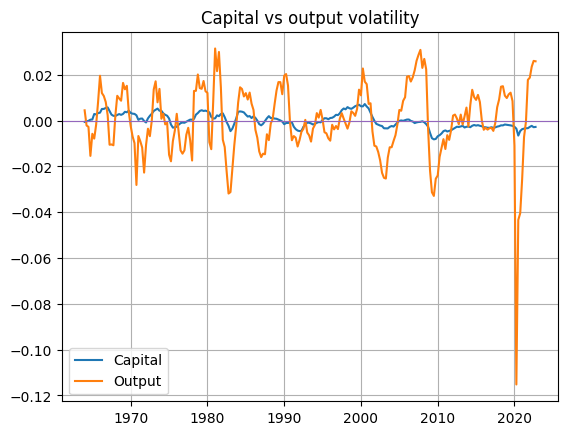

In [82]:
plt.plot((capital-np.mean(capital)), label = "Capital")   
plt.plot(cycle2.y, label = "Output")   
plt.legend()
plt.title("Capital vs output volatility")
plt.grid()
plt.axhline(y = 0, color = 'tab:purple', linestyle = '-', linewidth = 0.8)
plt.show()



• *Employment is as volatile as output, while hours per worker are much less volatile than output*: Yes (1.46 and 1.56 respectively). Hour per worker are much less volatile with their sd% 0.54 < 1.56


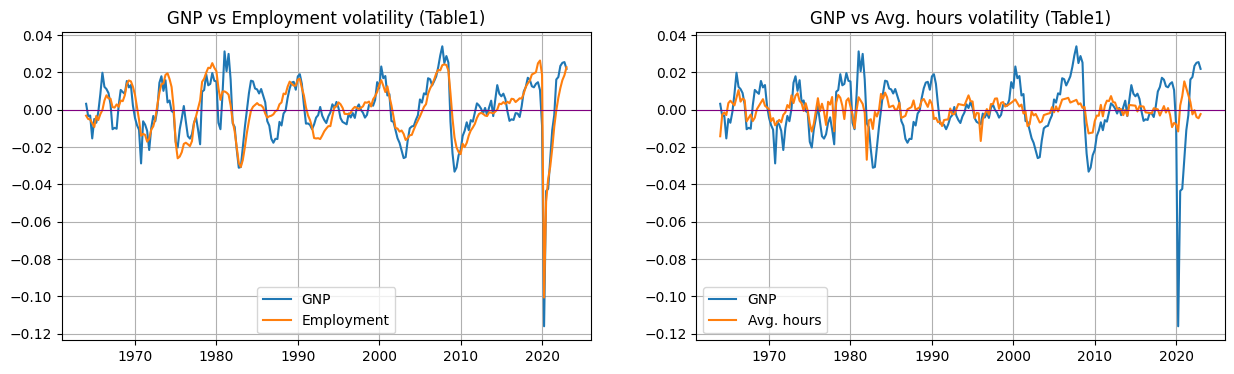

In [83]:
figure, axis = plt.subplots(1, 2)
figure.set_size_inches(15,4)

axis[0].plot(cycle1.gnp, label = "GNP")
axis[0].plot(cycle1.l, label = "Employment")
axis[0].axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
axis[0].set_title("GNP vs Employment volatility (Table1)")
axis[0].grid()
axis[0].legend(loc = 8)

axis[1].plot(cycle1.gnp, label = "GNP")
axis[1].plot(cycle1.aveh, label = "Avg. hours")
axis[1].axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
axis[1].set_title("GNP vs Avg. hours volatility (Table1)")
axis[1].grid()
axis[1].legend()

plt.show()



• *Labour productivity is less volatile than output*: Yes


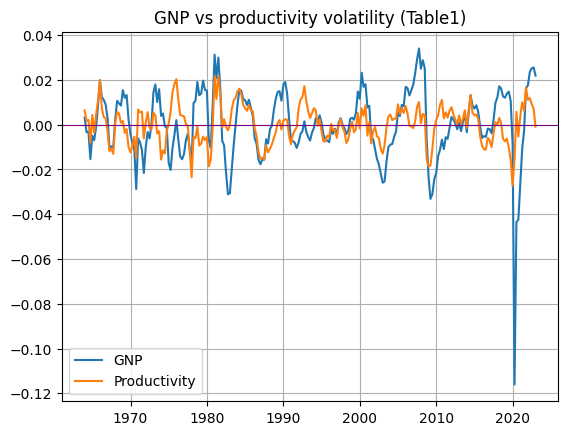

In [84]:
plt.plot(cycle1.gnp, label = "GNP")
plt.plot(cycle1["gnp/l"], label = "Productivity")
plt.legend()
plt.title("GNP vs productivity volatility (Table1)")
plt.grid()
plt.axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
plt.show()
plt.show()



• *The real wage is much less volatile than output*: Yes, real wage (w) sd is less than half output (y) sd

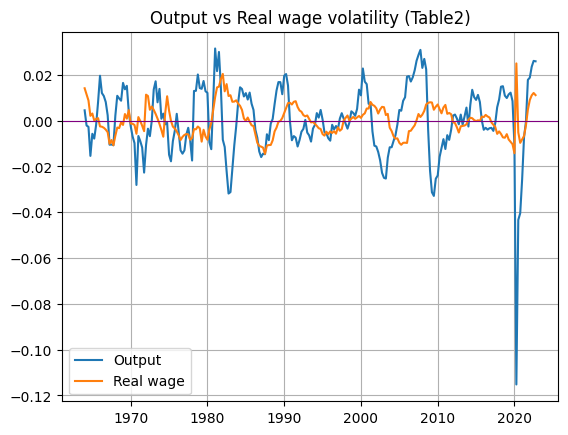

In [85]:
plt.plot(cycle2.y, label = "Output")
plt.plot(cycle2.w, label = "Real wage")   #yes
plt.legend()
plt.title("Output vs Real wage volatility (Table2)")
plt.grid()
plt.axhline(y = 0, color = 'purple', linestyle = '-', linewidth = 0.8)
plt.show()
plt.show()

---
---